In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from skfda.representation.basis import BSpline
import rpy2.robjects as robjects
from multiprocessing import Process, Queue
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Read in the Data

In [2]:
df = pd.read_csv('P04.csv', header=None)

### View the Data

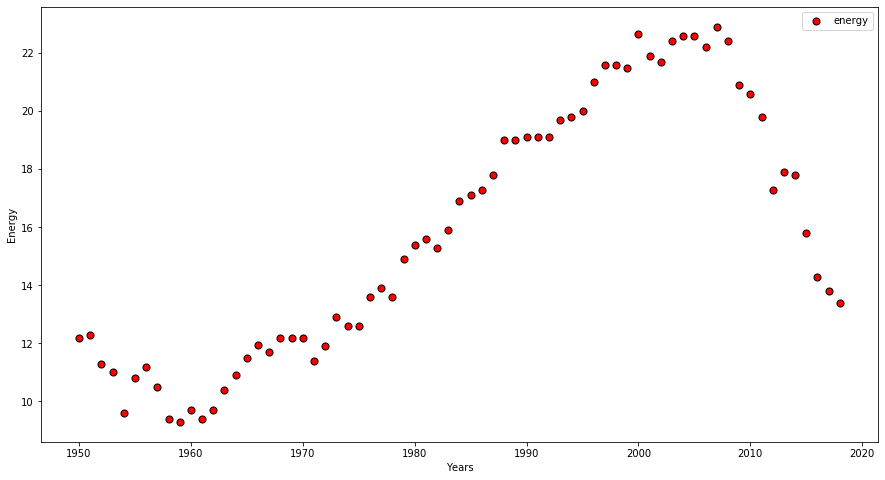

In [3]:
fig, axes = plt.subplots(figsize=(15,8))
ax=plt.subplot()
df.plot(kind='scatter', x=0, y=1, ax=ax, color='r', edgecolor='k', s=50, label='energy')
plt.xlabel('Years')
plt.ylabel('Energy')
plt.show()

### Separate x and y vectors

In [4]:
X = df[0].values
y = df[1].values

### Cubic Splines Implementation
This implementation is a python recreation of the R example code. It utilizes OLS to find the weight vector

In [5]:
def cubic_splines(x, y, **kwargs):
    '''
    inputs
    ------
    x      ->  Domain vector (independent variables)
    y      ->  Response vector (dependent variables)
    kwargs ->  should have any of the following options
               knots --> [list]: list of knots
               num_knots --> [int]: number of desired knots. These knots will be equidistant and calculated from input x
               
    outputs
    -------
    B     -> Weight matrix found from OLS
    yhat  -> Fitted data
    makeH -> Function needed to transform new unseen data
    '''
    if 'knots' in kwargs.keys():
        assert isinstance(kwargs['knots'], list), 'knots should be a list'
        knots = np.array(kwargs['knots'])

        

    elif 'num_knots' in kwargs.keys():
        assert isinstance(kwargs['num_knots'], int), 'num_knots should be an integer'
        knots = np.linspace(min(x), max(x), kwargs['num_knots'])
        
    '''
    This is a closure function that is a returned object from this function so a user can trasnform new unseen independent variables
    after initially fitting the training data with the supplied knots
    '''
    def wrapper(knots):
        def inner(x):
            basis = []

            h1 = 1
            h2 = x
            h3 = x**2
            h4 = x**3
            basis = [h1, h2, h3, h4]
            for i in range(len(knots)):
                h = (x - knots[i])**3
                if h <= 0:
                    h = 0
                basis.append(h)

            H = np.array(basis)
            return H
        return inner

    #create a transform function to be returned
    makeH = wrapper(knots)

    
    x = np.array(x)
    y = np.array(y)
    knots = np.array(knots)
    
    
    #1st basis function is all ones
    h1 = np.ones(len(x))
    
    #2nd basis function is linear
    h2 = x
    
    #3rd basis function is quadratic
    h3 = x**2
    
    #4th basis function is cubic
    h4 = x**3
    
    basis = [h1, h2, h3, h4]
    
    #get the truncated power basis for sigma_ki < x < sigma_ki+1
    for i in range(len(knots)):
        h = (x - knots[i])**3
        h[h <= 0] = 0
        
        basis.append(h)
    
    #transformation matrix
    H = np.array(basis)

    #weight vectors found from OLS
    B = np.dot(np.linalg.pinv(np.dot(H, H.T)), np.dot(H,y))

    #return weight vector, the fitted data, and the transformation function to transform new unseen data
    return B , np.dot(H.T,B), makeH

### Test out cubic splines on the data with 6 knots

In [6]:
b, yhatcs, transformfunc = cubic_splines(X,y,num_knots=6)

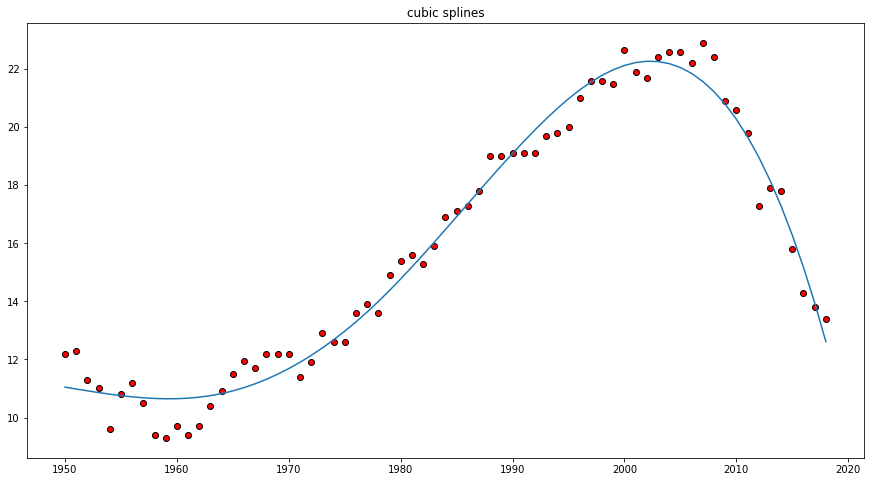

In [7]:
plt.figure(figsize=(15,8))
plt.scatter(X, y , color='r', edgecolor='k')
plt.plot(X, yhatcs)
plt.title('cubic splines')
plt.show()

### Cubic Splines MSE Function
The cubic_mse function can be ran as a single process but also supports a multiprocessing Queue object for multiprocessing of a hyperparameter gridsearch. It utilizes leave one out cross validation and aggregates the error for each left out independent variable predicted response. The errors from each LOO is then used to calculate the overall MSE. If a multiprocessing Queue object is supplied, the result is put on the queue and returned to the main process, otherwise the MSE is simply returned

In [8]:
def cubic_mse(x,y,num_knots, q=None):
    '''
    inputs
    ------
    x         -> the independent variable vector
    y         -> the dependent variable vector
    num_knots -> the number of knots to be used for the MSE calculation
    q         -> multiporcessing Queue object
    
    returns
    ------
    mse -> the mse for all errors for LOOCV
    '''
    #initialize empty array to hold all errors 
    preds = np.zeros(len(y))
    y_true = np.zeros(len(y))
    
    #perform LOOCV
    for i in range(len(y)):
        X = np.delete(x, i)
        Y = np.delete(y, i)
        
        #fit data on all indpendent variables except the value left out
        weights, fit, transform_func = cubic_splines(X, Y, num_knots=num_knots)
        
        #predict on the left out value
        xtest = x[i]
        xtest = transform_func(xtest)
        pred = np.dot(weights, xtest)
        
        #calculate error
        preds[i] = pred
        y_true[i] = y[i]
    
    #calculate mse
    mse = mean_squared_error(y_true, preds)
    
    
    #return mse
    if q == None:
        return mse
    else:
        q.put(mse)

### b-splines implementation
The b-splines implementation was created by using the skfda.representation.basis library and the BSpline object was utilized. The function takes in the independent and dependent variables along with the desired polynomial degree and returns the weight vector, the fitted data, and the object needed to transform new unseen data

In [9]:
def bspline(x, y, order, **kwargs):
    '''
    inputs
    ------
    x      -> The independent variable vector
    y      -> the dependent variable vector
    order  -> the degree of polynomia
    kwargs -> should have any of the following options
              knots --> [list]: list of knots
              num_knots --> [int]: number of desired knots. These knots will be equidistant and calculated from input x
              
    outputs
    -------
    B     -> Weight matrix found from OLS
    yhat  -> Fitted data
    bss   -> Object needed to transform new unseen data into an H tensor
    '''
    if 'knots' in kwargs.keys():
        assert isinstance(kwargs['knots'], (list, np.ndarray)), 'knots should be a list'
        knots = np.array(kwargs['knots'])

        

    elif 'num_knots' in kwargs.keys():
        assert isinstance(kwargs['num_knots'], int), 'num_knots should be an integer'
        knots = np.linspace(min(x), max(x), kwargs['num_knots'])
       
    #instantiate a b-splines object 
    bss = BSpline(knots=knots, order=order)
    
    #create the b-spline transformed tensors
    H = bss.evaluate(x)
    
    #find the weight vectors using OLS
    B = np.dot(np.linalg.pinv(np.dot(H, H.T)), np.dot(H,y))

    
    return B, np.dot(H.T,B), bss

### Test out b-splines with 6 knots and 2nd order polynomial

In [10]:
weights, yhatbs, transform_object = bspline(X, y, 2, num_knots=6)

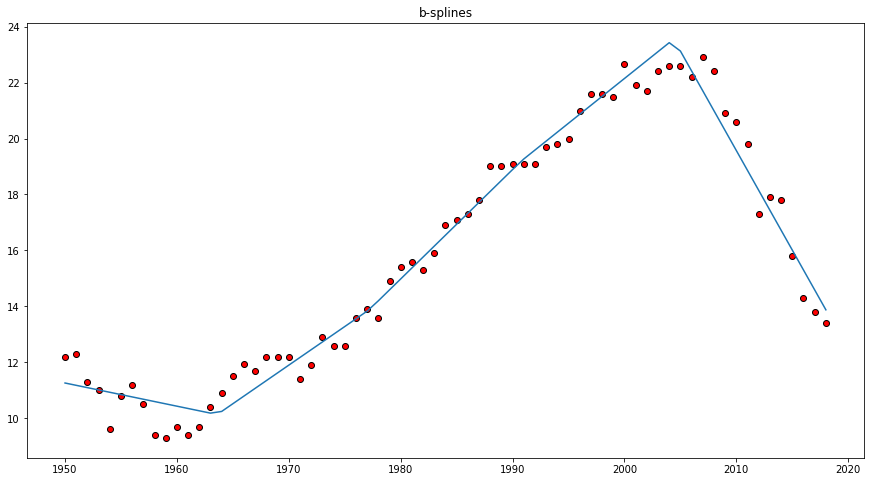

In [11]:
plt.figure(figsize=(15,8))
plt.scatter(X,y, color='r', edgecolor='k')
plt.plot(X, yhatbs)
plt.title('b-splines')
plt.show()

### b-Spline MSE Function
The bspline_mse function can be ran as a single process but also supports a multiprocessing Queue object for multiprocessing of a hyperparameter gridsearch. It utilizes leave one out cross validation and aggregates the error for each left out independent variable predicted response. The errors from each LOO is then used to calculate the overall MSE. If a multiprocessing Queue object is supplied, the result is put on the queue and returned to the main process, otherwise the MSE is simply returned


In [12]:
def bspline_mse(x, y, order, num_knots, q= None):
    '''
    inputs
    ------
    x         -> the independent variable vector
    y         -> the dependent variable vector
    order     -> polynomial degree
    num_knots -> the number of knots to be used for the MSE calculation
    q         -> multiporcessing Queue object
    
    returns
    ------
    mse -> the mse for all errors for LOOCV
    '''
    #initialize error array
    preds = np.zeros(len(y))
    y_true = np.zeros(len(y))
    
    #perform LOOCV
    for i in range(len(y)):
        X = np.delete(x, i)
        Y = np.delete(y, i)
        
        #fit the data on all indpendent variables except the left out value
        weights, fit, transform_object = bspline(X, Y, order=order, num_knots=num_knots)
        
        xtest = x[i]
        xtest = transform_object.evaluate([xtest])
        pred = np.dot(weights, xtest)
        
        preds[i] = pred
        y_true[i] = y[i]
        
    #calculate mse
    mse = mean_squared_error(y_true, preds)
    
    if q == None:
        return mse
    else:
        q.put(mse)

### Smoothing Spline implementation
The smoothing spline implmentation using the rpy2 library which allows for the direct usage of R function in python. The code is a Python implementation of the R example code provided. A closure function is created so new predictions can be made on unseen data with respect to the fit

In [13]:
def smoothing_splines(x, y, spar):
    '''
    inputs
    ------
    x -> independent variables
    y -> dependent variables
    spar -> smoothing parameter
    
    outputs
    -------
    yhat -> the fitted values
    pred_obj -> function used to predict on newe unseen data
    
    '''
    
    #get the smooth.spline function used by r
    smooth_spline = robjects.r['smooth.spline']

    #conver x and y to r objects
    x = robjects.FloatVector(list(x))
    y = robjects.FloatVector(list(y))

    #fit the data
    spline_obj = smooth_spline(x=x, y=y, spar=float(spar))
    
    
    '''
    This closure function is returned so predictions can be made on new unseen data.
    '''
    def wrapper(spline_obj):
        def inner(x):
            x = robjects.FloatVector(list(x))
            yspline = robjects.r['predict'](spline_obj,x).rx2('y')
            return np.array(yspline)
        return inner
    
    #create the prediction function
    predict_obj = wrapper(spline_obj)
    
    #return yhat and prediction function
    return np.array(spline_obj.rx2('y')) , predict_obj

### test out smoothing splines with a smoothing parameter of 0.5

In [14]:
yhatss, predict_obj = smoothing_splines(x=X, y=y, spar=0.5)

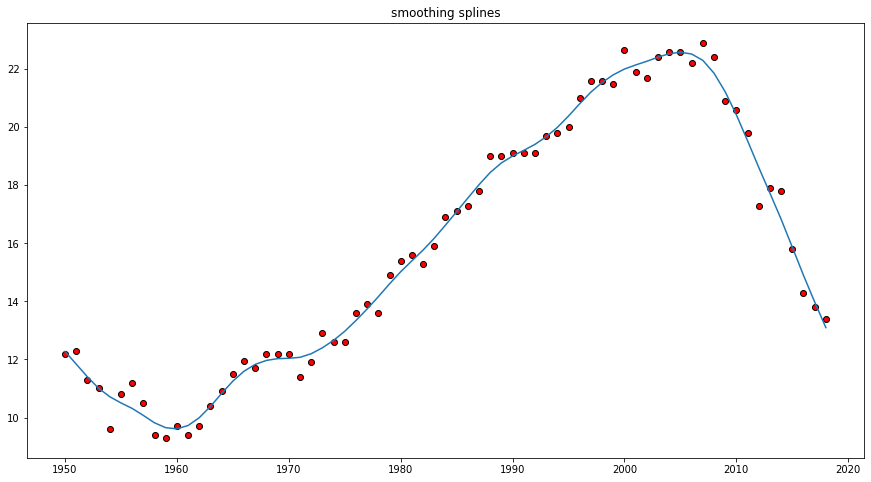

In [15]:
plt.figure(figsize=(15,8))
plt.scatter(X,y,color='r', edgecolor='k')
plt.plot(X,yhatss)
plt.title('smoothing splines')
plt.show()

### Smoothing Spline MSE Function
The smoothing_mse function can be ran as a single process but also supports a multiprocessing Queue object for multiprocessing of a hyperparameter gridsearch. It utilizes leave one out cross validation and aggregates the error for each left out independent variable predicted response. The errors from each LOO is then used to calculate the overall MSE. If a multiprocessing Queue object is supplied, the result is put on the queue and returned to the main process, otherwise the MSE is simply returned

In [16]:
def smoothing_mse(x, y, spar, q=None):
    '''
    inputs
    ------
    x         -> the independent variable vector
    y         -> the dependent variable vector
    spar      -> smoothing parameter
    q         -> multiporcessing Queue object
    
    returns
    ------
    mse -> the mse for all errors for LOOCV
    '''
    #initialize error array
    preds = np.zeros(len(y))
    y_true = np.zeros(len(y))
    
    #perform LOOCV
    for i in range(len(y)):
        X = np.delete(x, i)
        Y = np.delete(y, i)
        
        #fit data except left out indpendent variable
        fit, predict_object = smoothing_splines(X, Y, spar)
        
        #predict on left out value
        xtest = x[i]
        pred = predict_object([xtest])
        
        preds[i] = pred
        y_true[i] = y[i]
    
    #calculate mse
    mse = mean_squared_error(y_true, preds)
    
    if q == None:
        return mse
    else:
        q.put(mse)

### Gaussian kernel implementation
The guassian kernel function is a Python refactor of the R example code provided - It creates a closure function use for real time evaluation of independent variables

In [17]:
#kernel function
def kerf(z):
    kernel = np.exp(-z*z / 2) / np.sqrt(2*np.pi)
    return kernel



def gaussian_kernel(x,y,lambda_):
    '''
    inputs
    ------
    x         -> the independent variable vector
    y         -> the dependent variable vector
    lambda_   -> lambda value for kernel function
    
    returns
    ------
    func -> evaluation function for unseen independent variables
    '''

    
    def wrapper(x,y,lambda_):
        def inner(xtest):
            if not isinstance(xtest, (list, np.ndarray)):
                xtest = [xtest]
            N = len(xtest)
            f = np.zeros(N)

            for k in range(N):
                z = kerf((xtest[k] - x) / lambda_)
                f[k] = np.sum(z * y) / np.sum(z)

            return f
        return inner
    
    func = wrapper(x, y, lambda_)
    
    return func

### Test out gaussian kernel with a lambda value of 1.2

In [18]:
gk = gaussian_kernel(X,y,1.2)

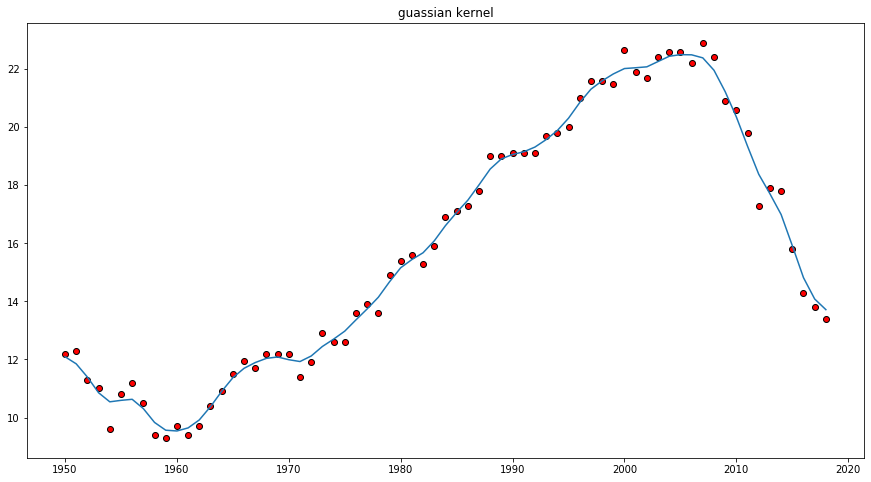

In [19]:
plt.figure(figsize=(15,8))
plt.scatter(X,y,color='r', edgecolor='k')
plt.plot(X, gk(X))
plt.title('guassian kernel')
plt.show()

### Gaussian Kernel MSE Function
The gaussian_mse function can be ran as a single process but also supports a multiprocessing Queue object for multiprocessing of a hyperparameter gridsearch. It utilizes leave one out cross validation and aggregates the error for each left out independent variable predicted response. The errors from each LOO is then used to calculate the overall MSE. If a multiprocessing Queue object is supplied, the result is put on the queue and returned to the main process, otherwise the MSE is simply returned

In [20]:
def gaussian_mse(x, y, lambda_, q=None):
    '''
    inputs
    ------
    x         -> the independent variable vector
    y         -> the dependent variable vector
    lambda_   -> lambda parameter
    q         -> multiporcessing Queue object
    
    returns
    ------
    mse -> the mse for all errors for LOOCV
    '''
    preds = np.zeros(len(y))
    y_true = np.zeros(len(y))
    
    for i in range(len(y)):
        X = np.delete(x, i)
        Y = np.delete(y, i)
        
        xtest = x[i]
        pred_obj = gaussian_kernel(x,y,lambda_)
        
        pred = pred_obj(xtest)
        
        preds[i] = pred
        y_true[i] = y[i]
        
    mse = mean_squared_error(y_true, preds)
    
    if q == None:
        return mse
    else:
        q.put(mse)

### Viewing all tests together

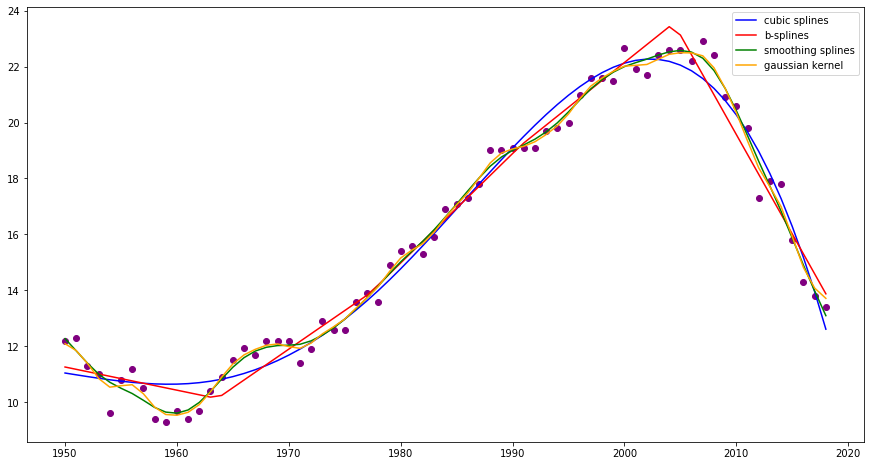

In [21]:
plt.figure(figsize=(15,8))
plt.scatter(X,y, color='purple')
plt.plot(X,yhatcs, color='blue', label='cubic splines')
plt.plot(X,yhatbs, color='red', label='b-splines')
plt.plot(X,yhatss, color='green', label='smoothing splines')
plt.plot(X,gk(X), color='orange', label='gaussian kernel')
plt.legend()
plt.show()

## LOOCV Implementation
This function utilizes multiprocessing and performs grid search across an array of hyperparameters for each algorithm. It returns a dictionary for each algorithm containing the best hyperparameter and the subsequent MSE value from the LOOCV

In [22]:
def LOOCV(x,y):
    '''
    inputs
    ------
    x -> independent variable
    y -> dependent variable
    
    outputs
    -------
    results -> dictionary containing results for each algorithm
    '''
    
    #range of knots to grid search over (knots low = 6, knots high = 15)
    knots = range(6,16)
    #polynomial orders to grid search over (order low = 1, order high = 5)
    orders = range(1,6)
    #smoothing parameters to grid search over (spar low = 0, spar high = 1)
    spars = np.linspace(0,1,100)
    #lambda parameters to grid search over (lambda low = 1, lambda high = 4)
    lambdas_ = np.arange(0.1,4,0.1)
    
    #initialize empty array to hold all caluclated MSEs for each hyperparameter grid searched over
    cs_mse = np.zeros(len(knots))
    bs_mse = np.zeros(len(knots) * len(orders))
    ss_mse = np.zeros(len(spars))
    gk_mse = np.zeros(len(lambdas_))
    
    #create a multiprocessing Queue object for each process to write results to
    cs_q = Queue()
    bs_q = Queue()
    ss_q = Queue()
    gk_q = Queue()
    
    #list to maintain PID for all created processes
    cs_process = []
    bs_process = []
    ss_process = []
    gk_process = []
    
    #cubic mse multiprocessing
    for i in knots:
        p = Process(target=cubic_mse, args=(x, y, i, cs_q))
        p.start()
        cs_process.append(p)
    
    #join results from each cubic process
    for pos, p in enumerate(cs_process):
        p.join()
        cs_mse[pos] = cs_q.get()
        
    
    #b-spline mse multiprocessing
    for i in knots:
        for j in orders:
            p = Process(target=bspline_mse, args=(x, y, j, i, bs_q))
            p.start()
            bs_process.append(p)
    
    #join results from each b-spline process
    for pos, p in enumerate(bs_process):
        p.join()
        bs_mse[pos] = bs_q.get()
        

    #smoothing splines mse multiprocessing
    for i in spars:
        p = Process(target=smoothing_mse, args=(x,y,i,ss_q))
        p.start()
        ss_process.append(p)
        
    #join results from each smoothing spline process
    for pos, p in enumerate(ss_process):
        p.join()
        ss_mse[pos] = ss_q.get()


    #guassian mse multiprocessing
    for i in lambdas_:
        p = Process(target=gaussian_mse, args=(x,y,i, gk_q))
        p.start()
        gk_process.append(p)
        
    #join results from each gaussian process
    for pos, p in enumerate(gk_process):
        p.join()
        gk_mse[pos] = gk_q.get()
        
        
        
    #plot results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,10))
    
    ax1 = plt.subplot(221)
    ax1.plot(knots, cs_mse)
    ax1.scatter(knots[np.argmin(cs_mse)], cs_mse[np.argmin(cs_mse)], color='red', s=50)
    ax1.set_xlabel('knots')
    ax1.set_ylabel('mse')
    ax1.set_title('cubic splines')
    
    ax2 = plt.subplot(222)
    points = [(k,o) for k in knots for o in orders]
    xp = [x[0] for x in points]
    yp = [x[1] for x in points]
    ax2.scatter(xp,yp, s=bs_mse * 300)
    ax2.scatter(xp[np.argmin(bs_mse)], yp[np.argmin(bs_mse)], color='r', s=bs_mse[np.argmin(bs_mse)]*300)
    plt.text(xp[np.argmin(bs_mse)], yp[np.argmin(bs_mse)] + 0.5, 'Min MSE = {}'.format(round(bs_mse[np.argmin(bs_mse)],2)), color='green')
    ax2.set_xlabel('knots')
    ax2.set_ylabel('polynomial order')
    ax2.set_title('b-splines')
    
    ax3 = plt.subplot(223)
    ax3.plot(spars, ss_mse)
    ax3.scatter(spars[np.argmin(ss_mse)], ss_mse[np.argmin(ss_mse)], color='r', s=50)
    ax3.set_xlabel('spars')
    ax3.set_ylabel('mse')
    ax3.set_title('Smoothing Splines')
    
    ax4 = plt.subplot(224)
    ax4.plot(lambdas_, gk_mse)
    ax4.scatter(lambdas_[np.argmin(gk_mse)], gk_mse[np.argmin(gk_mse)], color='r', s=50)
    ax4.set_xlabel('lambda')
    ax4.set_ylabel('mse')
    ax4.set_title('Gaussian Kernel')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    
    plt.show()
    
    
    results = {
                'cubic_splines':{'knot': knots[np.argmin(cs_mse)], 'mse':cs_mse[np.argmin(cs_mse)]},
                'bsplines': {'knot':xp[np.argmin(bs_mse)], 'order':yp[np.argmin(bs_mse)], 'mse':bs_mse[np.argmin(bs_mse)]},
                'smooth_splines': {'spar':spars[np.argmin(ss_mse)], 'mse':ss_mse[np.argmin(ss_mse)]},
                'gaussian_kernel': {'lambda':lambdas_[np.argmin(gk_mse)], 'mse':gk_mse[np.argmin(gk_mse)]}
              }
    
    
    results_string = '''
Cubic Splines:     Optimal Knots {}
                   MSE {}
               
               
B-Splines:         Optimal Knots {}
                   Optimal Degree {}
                   MSE {}
               
               
Smoothing Splines: Optimal Smoothing Parameter {}
                   MSE {}
                   
                   
Gaussian Kernel:   Optimal Lambda {}
                   MSE {}

'''.format(results['cubic_splines']['knot'],
           results['cubic_splines']['mse'],
           results['bsplines']['knot'],
           results['bsplines']['order'],
           results['bsplines']['mse'],
           results['smooth_splines']['spar'],
           results['smooth_splines']['mse'],
           results['gaussian_kernel']['lambda'],
           results['gaussian_kernel']['mse'])

    print(results_string)


    return results
    
    

### Perform LOOCV on Unscaled X data First

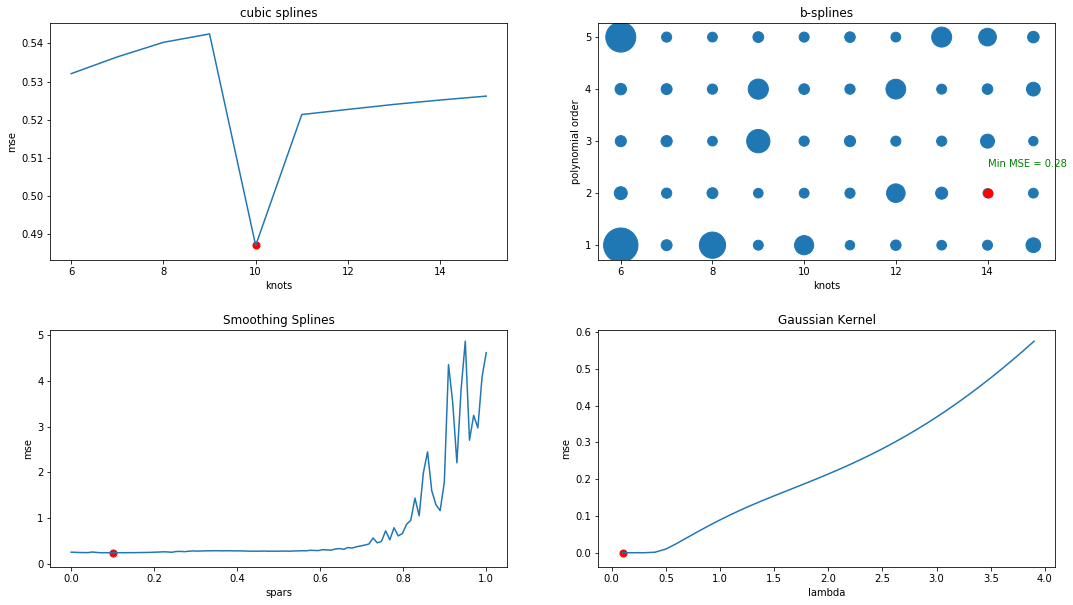


Cubic Splines:     Optimal Knots 10
                   MSE 0.4869035180512312
               
               
B-Splines:         Optimal Knots 14
                   Optimal Degree 2
                   MSE 0.2757741596820151
               
               
Smoothing Splines: Optimal Smoothing Parameter 0.10101010101010102
                   MSE 0.24488285318203684
                   
                   
Gaussian Kernel:   Optimal Lambda 0.1
                   MSE 1.0060834733253483e-30




In [23]:
results = LOOCV(X,y)

### Utilizing best parameters for each algorithm

In [24]:
cs_knots = results['cubic_splines']['knot']
bs_knots = results['bsplines']['knot']
bs_degree = results['bsplines']['order']
ss_spar = results['smooth_splines']['spar']
gk_lambda = results['gaussian_kernel']['lambda']

In [25]:
b, yhatcs, transformfunc = cubic_splines(X,y,num_knots=cs_knots)
weights, yhatbs, transform_object = bspline(X, y, bs_degree, num_knots=bs_knots)
yhatss, predict_obj = smoothing_splines(x=X, y=y, spar=ss_spar)
gk = gaussian_kernel(X,y,gk_lambda)

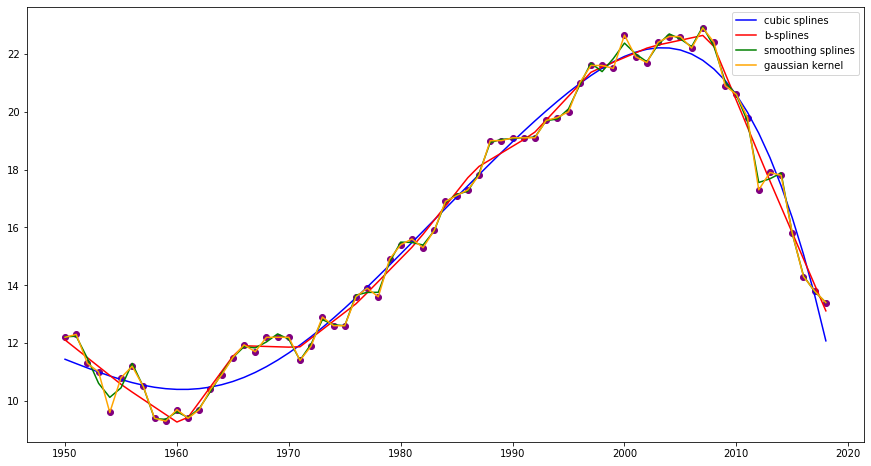

In [26]:
plt.figure(figsize=(15,8))
plt.scatter(X,y, color='purple')
plt.plot(X,yhatcs, color='blue', label='cubic splines')
plt.plot(X,yhatbs, color='red', label='b-splines')
plt.plot(X,yhatss, color='green', label='smoothing splines')
plt.plot(X,gk(X), color='orange', label='gaussian kernel')
plt.legend()
plt.show()

### Perform LOOCV on Scaled Data

In [27]:
scaler = StandardScaler()
scaler.fit(X.reshape(-1, 1))
X_transformed = scaler.transform(X.reshape(-1, 1))
X_transformed = np.array([i[0] for i in X_transformed.tolist()])

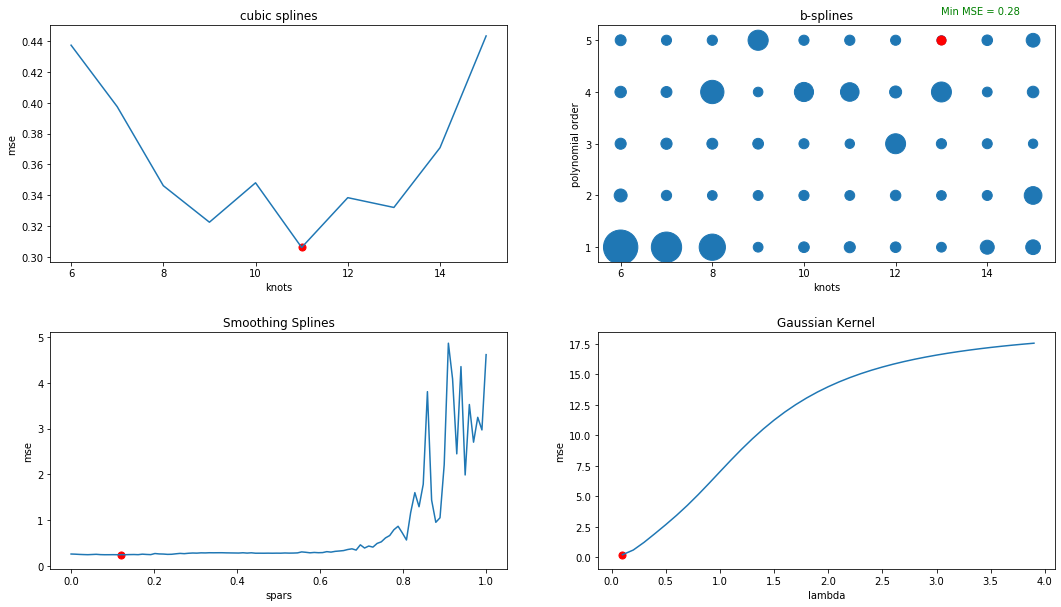


Cubic Splines:     Optimal Knots 11
                   MSE 0.30610506353725286
               
               
B-Splines:         Optimal Knots 13
                   Optimal Degree 5
                   MSE 0.27577415968201885
               
               
Smoothing Splines: Optimal Smoothing Parameter 0.12121212121212122
                   MSE 0.24488285318203865
                   
                   
Gaussian Kernel:   Optimal Lambda 0.1
                   MSE 0.21302888604096862




In [28]:
results = LOOCV(X_transformed,y)

In [29]:
cs_knots = results['cubic_splines']['knot']
bs_knots = results['bsplines']['knot']
bs_degree = results['bsplines']['order']
ss_spar = results['smooth_splines']['spar']
gk_lambda = results['gaussian_kernel']['lambda']

In [30]:
b, yhatcs, transformfunc = cubic_splines(X,y,num_knots=cs_knots)
weights, yhatbs, transform_object = bspline(X, y, bs_degree, num_knots=bs_knots)
yhatss, predict_obj = smoothing_splines(x=X, y=y, spar=ss_spar)
gk = gaussian_kernel(X,y,gk_lambda)

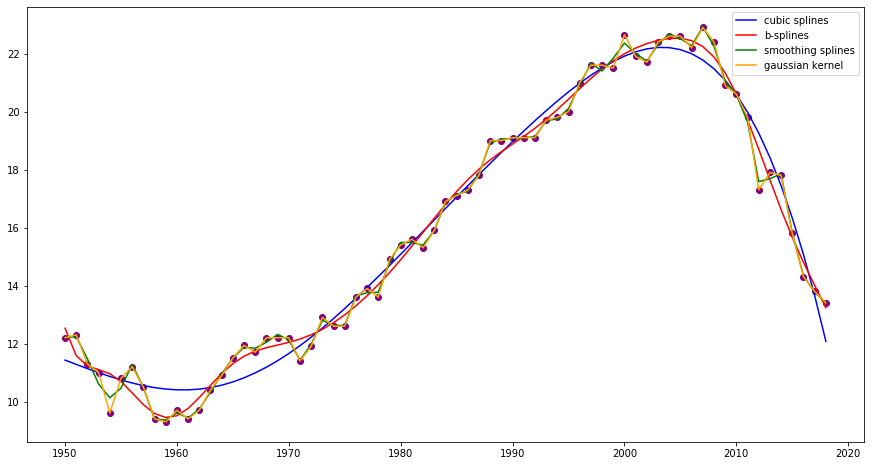

In [31]:
plt.figure(figsize=(15,8))
plt.scatter(X,y, color='purple')
plt.plot(X,yhatcs, color='blue', label='cubic splines')
plt.plot(X,yhatbs, color='red', label='b-splines')
plt.plot(X,yhatss, color='green', label='smoothing splines')
plt.plot(X,gk(X), color='orange', label='gaussian kernel')
plt.legend()
plt.show()

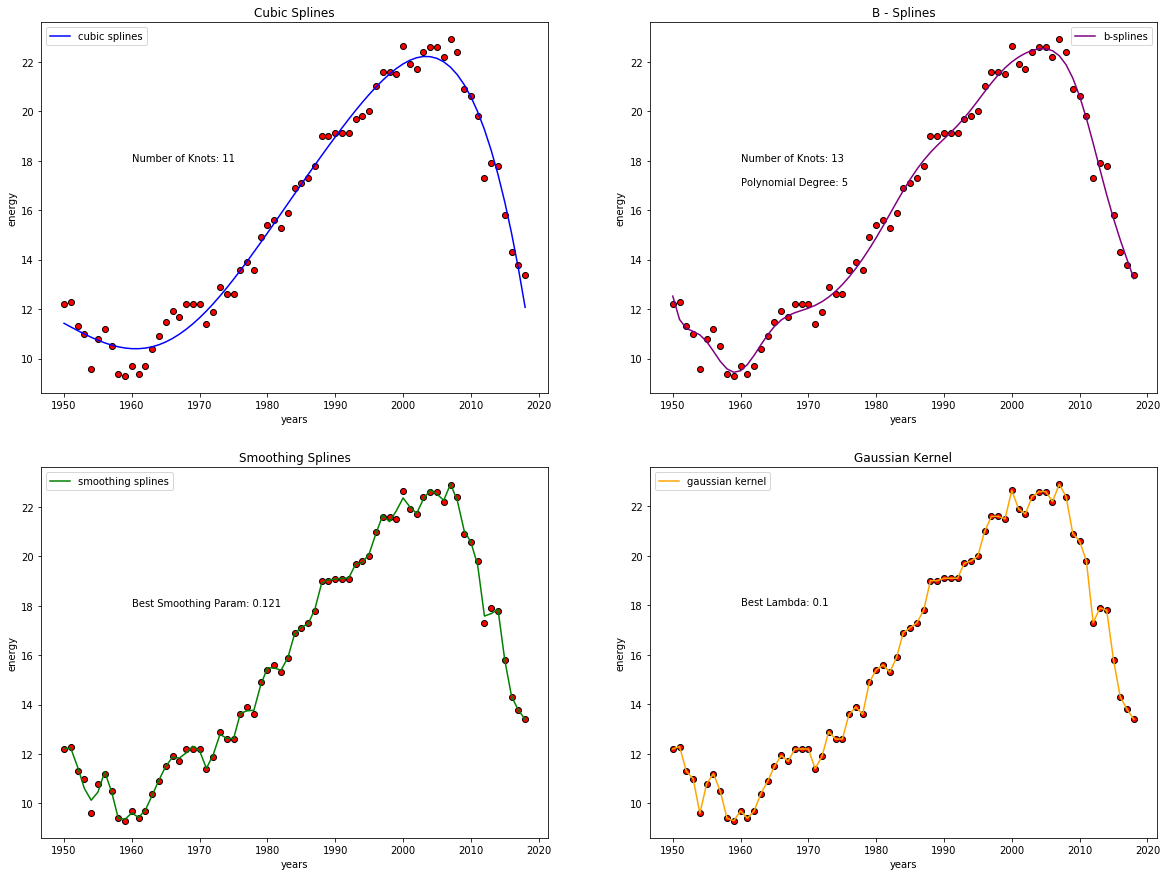

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

ax1 = plt.subplot(221)
ax1.scatter(X,y, color='red', edgecolor='k')
ax1.plot(X,yhatcs, color='blue', label='cubic splines')
ax1.set_xlabel('years')
ax1.set_ylabel('energy')
ax1.set_title('Cubic Splines')
plt.text(1960, 18, 'Number of Knots: {}'.format(cs_knots))
plt.legend()

ax2 = plt.subplot(222)
ax2.scatter(X,y, color='red', edgecolor='k')
ax2.plot(X,yhatbs, color='purple', label='b-splines')
ax2.set_xlabel('years')
ax2.set_ylabel('energy')
ax2.set_title('B - Splines')
plt.text(1960, 18, 'Number of Knots: {}'.format(bs_knots))
plt.text(1960, 17, 'Polynomial Degree: {}'.format(bs_degree))
plt.legend()

ax3 = plt.subplot(223)
ax3.scatter(X,y,color='red', edgecolor='k')
ax3.plot(X,yhatss, color='green', label='smoothing splines')
ax3.set_xlabel('years')
ax3.set_ylabel('energy')
ax3.set_title('Smoothing Splines')
plt.text(1960, 18, 'Best Smoothing Param: {}'.format(round(ss_spar,3)))
plt.legend()

ax4 = plt.subplot(224)
ax4.scatter(X,y, color='red', edgecolor='k')
ax4.plot(X,gk(X), color='orange', label='gaussian kernel')
ax4.set_xlabel('years')
ax4.set_ylabel('energy')
ax4.set_title('Gaussian Kernel')
plt.text(1960, 18, 'Best Lambda: {}'.format(gk_lambda))
plt.legend()
plt.show()